In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import h5py
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [3]:
data_path = "/Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/radon/5/"
flist = glob(data_path + "Alpha*.h5")

Fs = 125e6/8 ## Hz, decimation factor 8

alpha_dict = {'Po-212': 8784.86, 'Bi-212': 6050.8, 'Rn-220': 6288.1, 'Po-216': 6778.3}

In [4]:
def create_trap_filt(Fs, trise, ttop):
    nrise = int(trise*Fs)
    ntop = int(ttop*Fs)

    rise_vec = np.linspace(0,1,nrise)
    top_vec = np.ones(ntop)

    out_vec = np.hstack( (rise_vec, top_vec, rise_vec[::-1]) )

    if(False):
        plt.plot(out_vec)
    
    return out_vec/np.sum(out_vec)

In [5]:
def trap_filt(y, temp):
    return np.convolve(y, temp, mode='same')

In [6]:
def ffn(x, A, t0, rt=2.7976149071029696e-07, ft=1.533437162044799e-05):
    xx = x-t0
    xx[xx < 0] = 0
    out_vec = A*np.exp(-xx/ft)*(1-np.exp(-xx/rt))
    out_vec[x < t0] = 0
    return out_vec

In [7]:
def make_template_pulse(flist, npulses):
    
    fit_vec = np.zeros( (npulses, 4) )
    for i,f in enumerate(flist[:npulses]):

        currf = h5py.File(f, 'r')

        t, v = np.array(currf['time']), np.array(currf['voltage'])

        spars = [-5,1e-6,10e-6,4e-4]
        bp,_ = curve_fit(ffn, t, v, p0=spars)

        fit_vec[i,:] = bp

    return fit_vec


In [8]:
bp = make_template_pulse(flist, 100)

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_49209/1945116580.py:4: RuntimeWarning: overflow encountered in exp
  out_vec = A*np.exp(-xx/ft)*(1-np.exp(-xx/rt))
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_49209/1945116580.py:4: RuntimeWarning: invalid value encountered in multiply
  out_vec = A*np.exp(-xx/ft)*(1-np.exp(-xx/rt))
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_49209/1945116580.py:4: RuntimeWarning: overflow encountered in multiply
  out_vec = A*np.exp(-xx/ft)*(1-np.exp(-xx/rt))


0.00047506084417841193 3.6957404337551564e-07


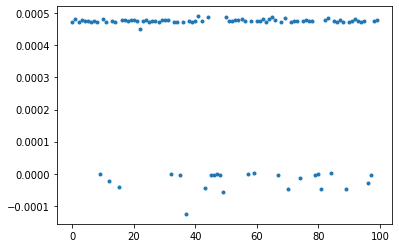

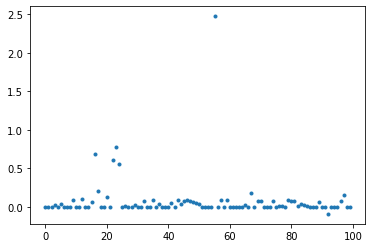

In [9]:


plt.figure()
plt.plot(bp[:,1], '.')

plt.figure()
plt.plot(bp[:,2], '.')

print(np.median(bp[:,1]), np.median(bp[:,2]))

In [77]:
remake_file = True
do_fit = True

tf = create_trap_filt(Fs, 1e-6, 5e-6)

filt_dat = []

for i,f in enumerate(flist):

    if( i % 1000 == 0): print("Working on file %d"%i)

    currf = h5py.File(f, 'r')

    t, v = np.array(currf['time']), np.array(currf['voltage'])

    v -= np.median(v[:1000])

    v_trap_filt = -1 * trap_filt(v, tf) #flip right side up
    s = np.std(v_trap_filt[:2000])
    max_deriv = np.max(np.gradient(v_trap_filt)) #maximum of the derivative to throw out slow pulses

    ## find all the peaks
    peaks, _ = find_peaks(v_trap_filt, height = 10*s, distance=1000)
    for p in peaks:
        ## baseline just before:
        bl = np.median(v_trap_filt[(p-200):(p-100)])

        if(do_fit):
            gpts = (t > t[p-300]) & (t > t[p+500])
            try:
                bp,_ = curve_fit(ffn, t, v, p0=[v_trap_filt[p], t[p]])
                chi2 = np.sum( (v[gpts] - ffn(t[gpts], *bp))**2 ) 
            except:
                bp = [0,0]
                chi2 = -1
        else:
            bp = [0,0]
            chi2 = -1

        ## 0: filtered amplitude, 1: maximum of the derivative, 2: baseline, 3: fit amplitude, 4: fit chi2, 5: file index
        filt_dat.append([v_trap_filt[p], max_deriv, bl, bp[0], chi2, i])

        #ispo216 = (bp[0]>-3.65 and bp[0]< -3.6)
        if(False):
            print(chi2, np.polyval([10,-10,35], bp[0]))
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,2)
            plt.plot(t,-v)
            plt.plot(t,v_trap_filt)
            plt.plot(t, -ffn(t, *bp) )
            #plt.xlim(t[p-300], t[p+500])

            plt.subplot(1,2,1)
            currf = h5py.File(flist[i-1], 'r')
            t, v = np.array(currf['time']), np.array(currf['voltage'])
            plt.plot(t,-v)
            plt.show()


if(remake_file):
    np.save("pulse_heights.npy", filt_dat)

Working on file 0
Working on file 1000
Working on file 2000
Working on file 3000
Working on file 4000
Working on file 5000


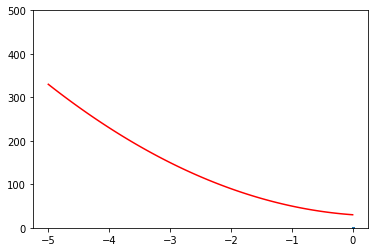

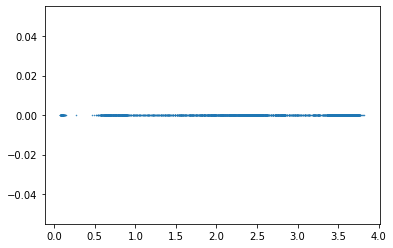

In [79]:
filt_dat = np.load("pulse_heights.npy")
xx = np.linspace(0,-5,100)
plt.plot(filt_dat[:,3], filt_dat[:,4], '.', ms=1)
plt.plot(xx, np.polyval([10,-10,30], xx), 'r')
plt.ylim(0,500)

plt.figure()
plt.plot(filt_dat[:,0], filt_dat[:,3], '.', ms=1)

In [82]:
bins = np.linspace(0, 5, 1500)
h, b = np.histogram(filt_dat[:,3], bins=600) #bins)
hfilt, bfilt = np.histogram(filt_dat[:,0], bins=600) #bins)
bc = b[:-1] + np.diff(b)/2
bcfilt = bfilt[:-1] + np.diff(bfilt)/2

In [87]:
plt.figure(figsize=(8,6))
cal_fac = 6051/bc[np.argmax(h)]
cal_fac_filt = 6051/bcfilt[np.argmax(hfilt)]

cal_dat = filt_dat[:,3] * cal_fac

plt.plot(bc*cal_fac, h)
plt.plot(bcfilt*cal_fac_filt, hfilt)
yy = plt.ylim()
for k in alpha_dict.keys():
    plt.plot(alpha_dict[k]*np.ones(2), yy, '--', label=k)

plt.legend()
plt.xlim(5000,10000)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.show()

IndexError: index 300 is out of bounds for axis 0 with size 99

<Figure size 576x432 with 0 Axes>

(5800.0, 7000.0)

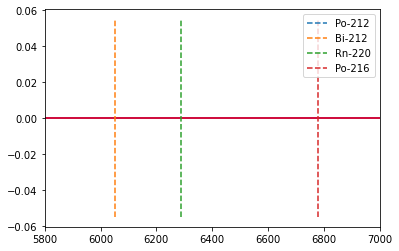

In [85]:
po216 = (cal_dat > 6700) & (cal_dat < 6800)

rn220 = np.roll(po216,-1)
junk = np.roll(po216,1)

bins = np.linspace(0, 10000, 100)
h1, b = np.histogram(cal_dat[rn220], bins=bins)
h2, b = np.histogram(cal_dat[junk], bins=bins)
bc = b[:-1] + np.diff(b)/2

plt.figure()
plt.plot(bc, h1, 'b')
plt.plot(bc, h2, 'r')